## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are:

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise and clean data;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task, but feel free to add additional cells to structure your notebook. Note that some questions require writing code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (**with the correct results displayed**) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code can run correctly on the original data file.

This assignment uses the standard best practice machine learning workflow, building on the first assignment and course workshops, and so less detailed instructions are provided for this assignment. You should be able to implement this workflow now without low-level guidance and a substantial portion of the marks for this assignment are associated with the appropriate choices and executing this workflow correctly and efficiently. Make sure you have clean, readable code as well as producing outputs, since your coding will also count towards the marks (however, excessive commenting is discouraged and will lose marks, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. Other libraries should not be used (even though they might have nice functionality) and occasionally certain specific functions need to be used, which will be made clear in the instruction text. You are expected to make sure that you are using functions correctly, and you should search and carefully read the documentation if unsure.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures most of the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. Their method employs efficient stochastic sampling, making it much faster than existing methods, although slightly noisier. This method does not measure any of the 'worst' features that appear in the *Wisconsin Breast Cancer Data Set*. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 - 1) Have at least a 90% probability of detecting malignant cancer when it is present;
 - 2) Ensure that no more than 1 in 5 healthy cases (those with benign growths) result in a false positive (labeled as malignant).

They have hand-labelled 220 samples for you, with 20 features per sample, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail.

## 1. Load data, visualise it and identify erroneous values [30%]

 - Load the data from the csv file `assignment2_data_2024.csv` (found on MyUni).
 - Extract the feature names and label names for use later on.
 - Provide at least one text summary of the dataset. This should include key information and characteristics of the data.
 - Create one graphical plot per feature. Each plot must display the feature values for the two classes (malignant and benign) separately on a single axis/panel.
 - Make sure you clearly label the graphical plots with respect to feature names, axes, classes, etc.
 - Identify any erroneous values in the dataset during the data visualisation or summary steps. Determine and implement, here or later, the appropriate action to handle these values (e.g., removal, correction, or none).
 - Throughout this assignment, treat the _malignant_ cases as the _true positive_ class, following the standard convention in medicine.
.

In [1]:
# This code imports some libraries that you will need.
# You should not need to modify it, though you are expected to make other imports later in your code.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time

# Pandas for overview
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

Feature_names: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error']
label_names ['malignant', 'maligant', 'benign']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    220 non-null    object 
 1   mean radius              220 non-null    object 
 2   mean texture             220 non-null    float64
 3   mean perimeter           220 non-null    float64
 4   mean area                220 non-null    float64
 5   mean smoothness          220 non-null    float64
 6   mean compact

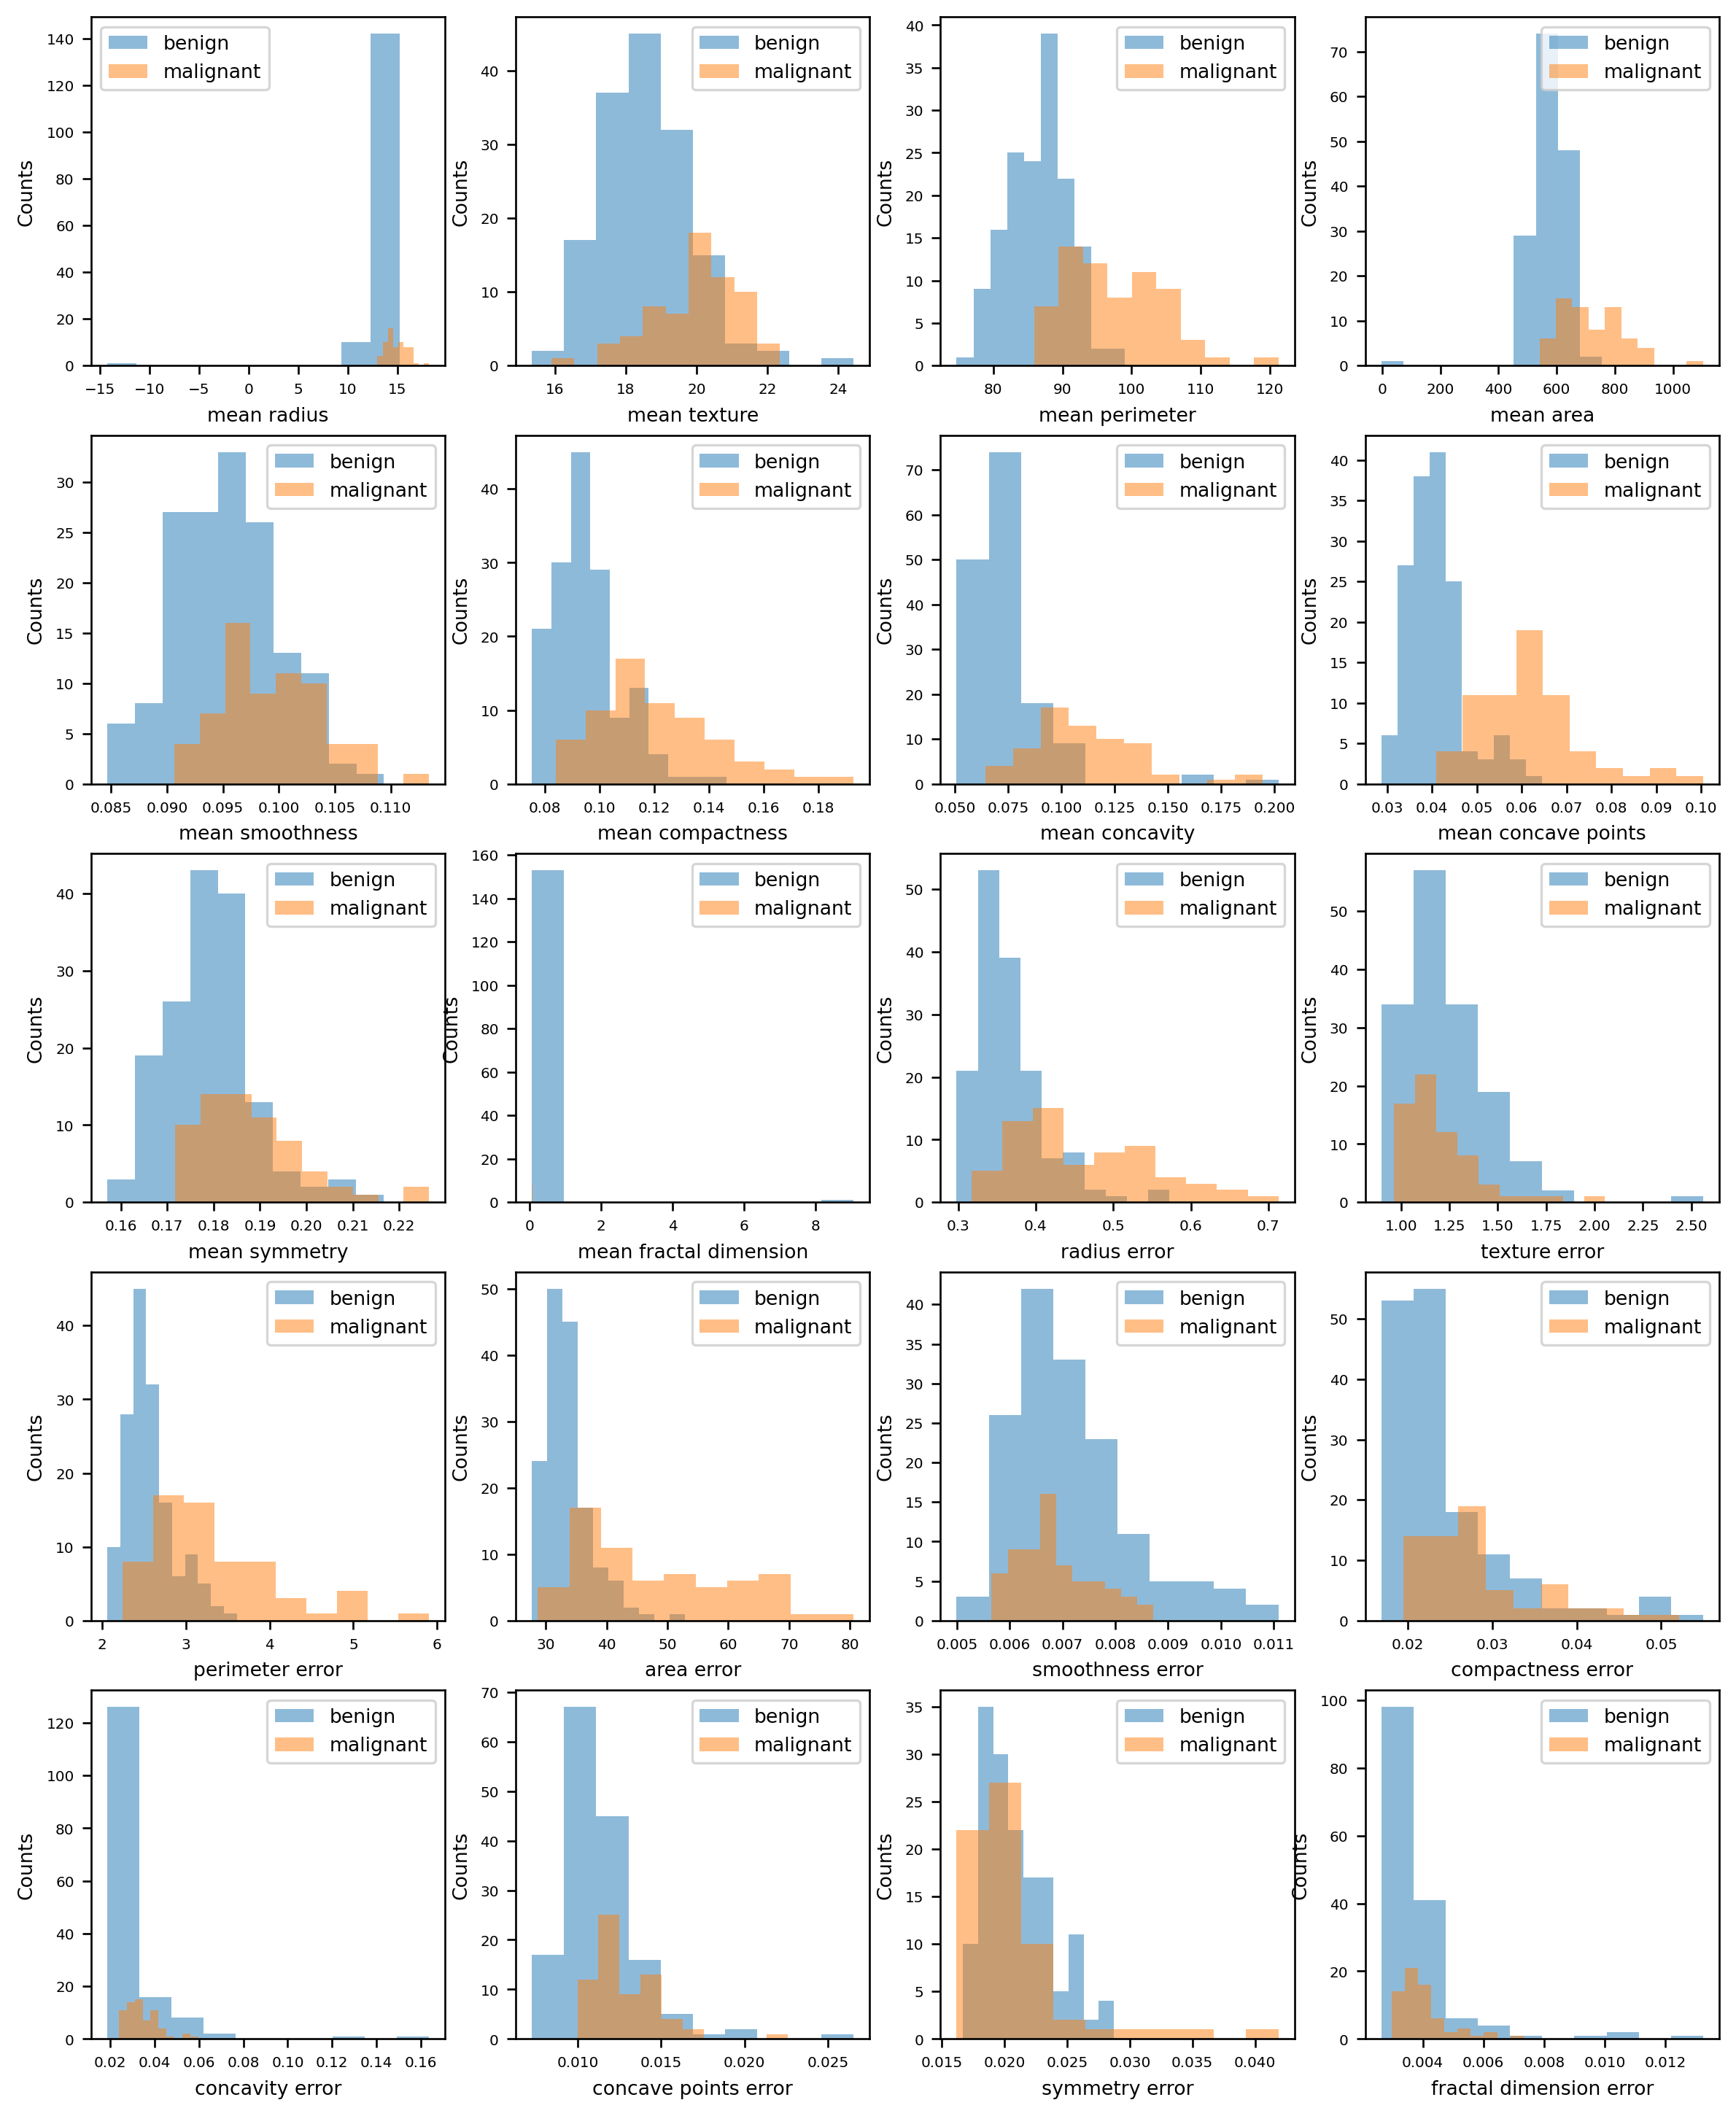

In [2]:
# Your code here

random_state = 1901276


#
# Load the data from the csv file `BreastCancerData.csv` 
#
csv_data = pd.read_csv('BreastCancerData.csv')


#
# Extract the feature names and label names for use later on.
#
feature_names = list(csv_data.columns[1:])
label_names = list(csv_data['label'].unique())
print('Feature_names:', feature_names)
print('label_names', label_names)
print('\n')


#
# Provide at least one text summary of the dataset. 
# This should include key information and characteristics 
# of the data.
#
csv_data.info()
print('\n')


#
# Identify any erroneous values in the dataset during 
# the data visualisation or summary steps. 
# Determine and implement, here or later, the appropriate action
#  to handle these values (e.g., removal, correction, or none).
#
# 1. Correction: Typo 'maligant'   (From printed label_names)
csv_data['label'] = csv_data['label'].replace('maligant', 'malignant')
# 2. Change type  （From .info())
csv_data['mean radius'] = csv_data['mean radius'].apply(pd.to_numeric, errors='coerce')


#
# Create one graphical plot per feature. 
# Each plot must display the feature values for the two classes
# (malignant and benign) separately on a single axis/panel.
#
# Make sure you clearly label the graphical plots 
# with respect to feature names, axes, classes, etc.
#
benign_data = csv_data[csv_data['label'] == 'benign']
malignant_data = csv_data[csv_data['label'] == 'malignant']
fontdict = {'size': 8}
plt.figure(figsize=(12, 15)) # 20 features, thus is 4x5
for i, feature_name in enumerate(feature_names):
    plt.subplot(5, 4, i + 1)
    plt.hist(benign_data[feature_name], alpha=0.5, label='benign')
    plt.hist(malignant_data[feature_name], alpha=0.5, label='malignant')
    plt.legend(prop=fontdict)
    plt.xlabel(feature_name, fontdict=fontdict)
    plt.ylabel('Counts', fontdict=fontdict)
    # plt.title(f'Hist of {feature_name}', fontdict=fontdict)


#
# Identify any erroneous values in the dataset during 
# the data visualisation or summary steps. 
# Determine and implement, here or later, the appropriate action
#  to handle these values (e.g., removal, correction, or none).
#
# 3. Impute: mean radius should be larger than zero.
csv_data['mean radius'] = csv_data['mean radius'].apply(lambda x: np.nan if x < 0 else x)
# 4. Impute: mean fractal dimension should not be larger than 3 in the context of breast cancer. (According to Wiki)
csv_data['mean fractal dimension'] = csv_data['mean fractal dimension'].apply(lambda x: np.nan if x > 3.0 else x)


#
# Throughout this assignment, treat the _malignant_ cases as 
# the _true positive_ class, following the standard convention 
# in medicine.
#
csv_data['label'] = csv_data['label'].map({'benign': 0, 'malignant': 1})


## 2. Prepare data and models, and make baseline measurements [20%]
 - Split data into appropriate sets using the `stratify` option to obtain consistent proportions of classes in each set.
 - Decide on appropriate pre-processing steps for the data.
 - Implement a _very_ simple baseline model that makes purely random predictions of the class.
 - Measure the baseline performance with the following metrics:
   - accuracy
   - balanced accuracy: accounts for imblanaced datasets, defined as _(sensitivity + specificity)/2_
   - recall
   - precision
   - auc
   - f1score
   - fbeta_scores with beta=0.1
   - fbeta_score with beta=10
 - Also display a confusion matrix for the baseline predictions.
 - As a second baseline, implement an SGD classifier and fit it once (without hyper-parameter optimisation) and then display the same performance metrics and a confusion matrix for its results.

In [3]:
# Some helpful code that you can use if you wish (or not)

from sklearn.metrics import fbeta_score, make_scorer

f10_scorer = make_scorer(fbeta_score, beta=10)
f01_scorer = make_scorer(fbeta_score, beta=0.1)

def f10_score(yt,yp):
    return fbeta_score(yt, yp, beta=10)

def f01_score(yt,yp):
    return fbeta_score(yt, yp, beta=0.1)

Random guess baseline model:
accuracy:          0.4772727272727273
balanced accuracy: 0.4950372208436724
recall:            0.5384615384615384
precision:         0.2916666666666667
auc:               0.4950372208436724
f1 score:          0.3783783783783784
fbeta score (0.1): 0.29299627020306673
fbeta score (10):  0.533987915407855


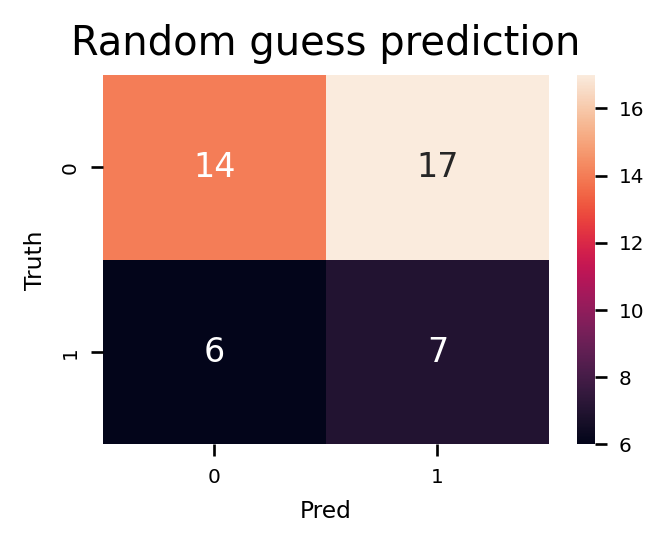



SGD baseline model:
accuracy:          0.9090909090909091
balanced accuracy: 0.913151364764268
recall:            0.9230769230769231
precision:         0.8
auc:               0.913151364764268
f1 score:          0.8571428571428571
fbeta score (0.1): 0.8010575016523463
fbeta score (10):  0.9216730038022817


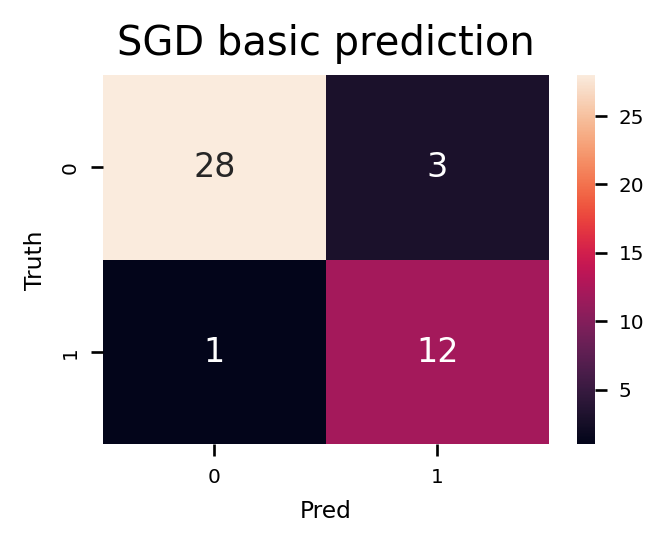

In [4]:
# Your code here

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.linear_model import SGDClassifier


#
# Split data into appropriate sets using the `stratify` option 
# to obtain consistent proportions of classes in each set.
#
X = csv_data.drop('label', axis=1)
y = csv_data['label']
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.25, stratify=y_train_all, random_state=random_state)


#
# Decide on appropriate pre-processing steps for the data.
#
preproc_pl = Pipeline([
    ### Justification of choosing median imputer:
    # The median is less affected by outliers compared to the mean,
    # as it prevents the imputation process from being skewed by extreme 
    # values. The median provides a better measure of central tendency for such 
    # distributions, ensuring that the imputed values are representative of the 
    # underlying data.
    ('imputer', SimpleImputer(strategy='median')),    
    #### Justification of choosing standard scaler:
    # Standardizing features to have zero mean and unit variance ensures that 
    # all features contribute equally to the model. Given that some features 
    # exhibit long-tail distributions, MinMaxScaler is not chosen as it can be 
    # sensitive to outliers and may not handle skewed data effectively. Since 
    # the extreme values have already been removed from the dataset and most of 
    # the distributions are not very skewed, the additional robustness to outliers 
    # provided by the Robust Scaler is not necessary. Therefore, the Standard Scaler 
    # is the most appropriate choice for this preprocessing step.
    ('std_scaler', StandardScaler())
])


#
# Implement a _very_ simple baseline model that makes purely 
# random predictions of the class.
#
np.random.seed(random_state)
y_pred_naive = np.random.choice([0, 1], size=y_val.shape[0])


#
# Measure the baseline performance with the following metrics:
#
def print_metrics(gt, pred):
    # - accuracy
    print('accuracy:         ', accuracy_score(gt, pred))
    # - balanced accuracy: accounts for imblanaced datasets,
    #   defined as _(sensitivity + specificity)/2_
    print('balanced accuracy:', balanced_accuracy_score(gt, pred))
    # - recall
    print('recall:           ', recall_score(gt, pred))
    # - precision
    print('precision:        ', precision_score(gt, pred))
    # - auc
    print('auc:              ', roc_auc_score(gt, pred))
    # - f1score
    print('f1 score:         ', f1_score(gt, pred))
    # - fbeta_scores with beta=0.1
    print('fbeta score (0.1):', f01_score(gt, pred))
    # - fbeta_score with beta=10
    print('fbeta score (10): ', f10_score(gt, pred))

print('Random guess baseline model:')
print_metrics(y_val, y_pred_naive)


#
# Also display a confusion matrix for the baseline predictions.
#
def draw_confusion(test, pred, title=None):
    conf_mat = confusion_matrix(test, pred)
    plt.figure(figsize=(3, 2))
    if title is not None:
        plt.title(title)
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.xlabel('Pred')
    plt.ylabel('Truth')
    plt.show()

draw_confusion(y_val, y_pred_naive, title='Random guess prediction')
print('\n')


#
# As a second baseline, implement an SGD classifier and fit it 
# once (without hyper-parameter optimisation) and then display 
# the same performance metrics and a confusion matrix for its
# results.
#
sgd = SGDClassifier(warm_start=True, learning_rate='constant', eta0=1e-5)
X_trainp = preproc_pl.fit_transform(X_train)
X_valp = preproc_pl.fit_transform(X_val)
sgd.fit(X_trainp, y_train)
y_pred_sgd = sgd.predict(X_valp)
print('SGD baseline model:')
print_metrics(y_val, y_pred_sgd)
draw_confusion(y_val, y_pred_sgd, title='SGD basic prediction')
print('\n')


## 3. Model Optimisation [40%]

### 3.1 Performance metric
Choose one performance metric from the above set. State your choice and explain why you chose it. [50 words maximum]

In [5]:
# Answer here
#
# The client requires restrictions on both False Negatives (FNs) and False 
# Positives (FPs), with a greater emphasis on minimizing FNs
# (FNR <= 10% vs. FPR <= 20%). Therefore, I chose the fbeta_score with beta=10 
# to balance these concerns, prioritizing the reduction of False Negatives.
#
# (Word count: 44)

### 3.2 Hyper-parameter optimisation
 - Perform a hyper-parameter optimisation (using appropriate methods) on three models:
   - SGD Classifer
   - SVM
   - One other model of your choice
 - Display the results of each model (including confusion matrices) and choose the best model.
 - Choose the best model and display the final results of this model.

1. SGD classifier:
best hyperparameters: {'alpha': 1e-05, 'loss': 'hinge', 'penalty': 'elasticnet'}
best score (fbeta, beta = 10): 0.9243237447538523


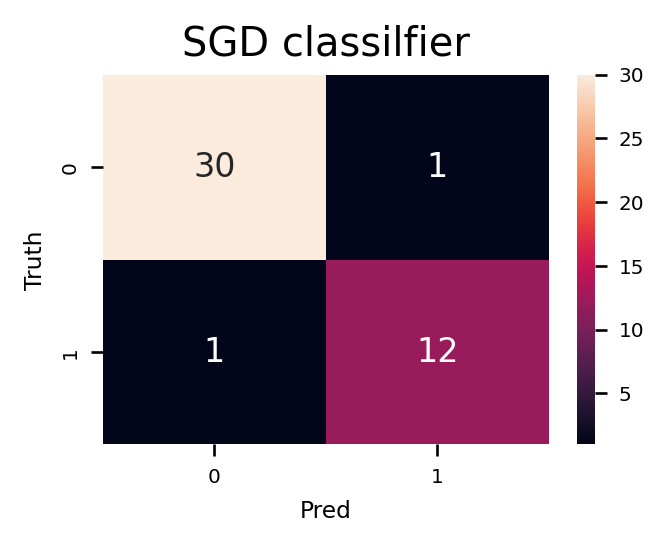



2. SVM
best hyperparameters: {'C': 10, 'kernel': 'linear'}
best score (fbeta, beta = 10): 0.9248175719143461


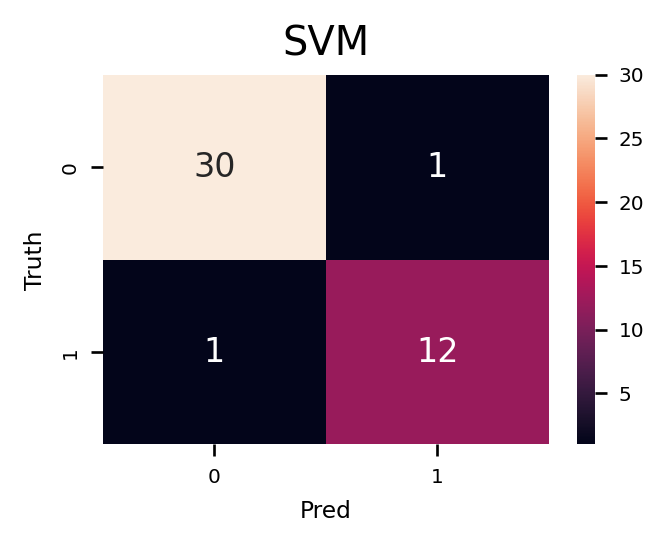



3. Other model (Decision Tree)
best hyperparameters: {'criterion': 'gini', 'max_features': None}
best score (fbeta, beta = 10): 0.8495098399177005


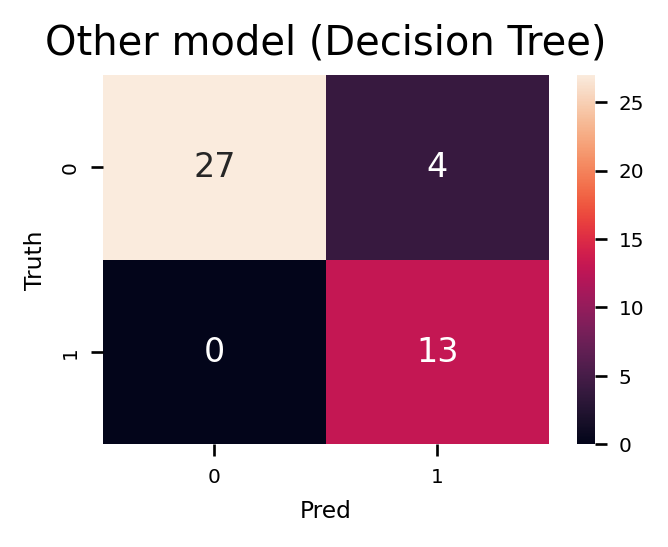



Best Model (SVM):
Test fbeta score (10):  0.9230769230769234


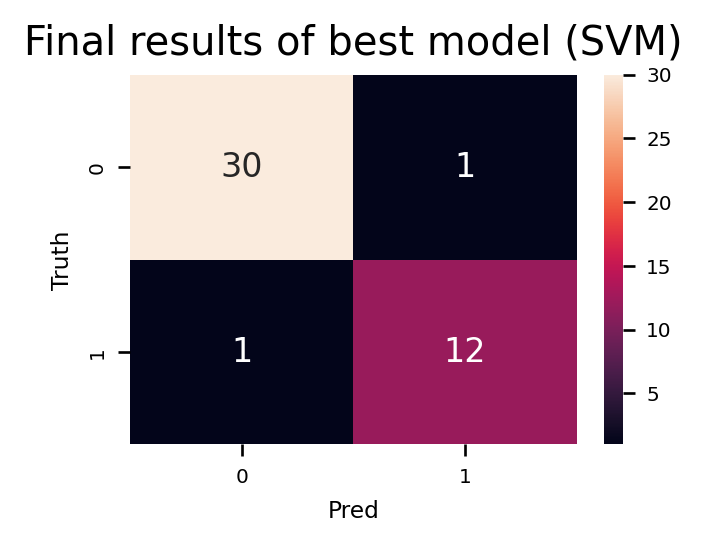

In [6]:
# Your code here

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


#
# Perform a hyper-parameter optimisation (using appropriate 
# methods) on three models:
#
# Display the results of each model (including confusion matrices) 
# and choose the best model.
#
X_trainp = preproc_pl.transform(X_train)
X_valp = preproc_pl.transform(X_val)

# - SGD Classifer
print('1. SGD classifier:')
sgd = SGDClassifier()
sgd_paras = {
    ### Loss Function:
    # 'hinge': Chosen for its effectiveness in many cases and 
    # compatibility with linear classifiers.
    # 'log_loss': Chosen for its ability to provide calibrated 
    # probabilities of class membership.
    'loss': ['hinge', 'log_loss'],
    ### Regularization Strength (alpha):
    # Covering a wide range of regularization strengths. 
    # These values were chosen to explore the impact of 
    # different regularization strengths, from minimal to strong,
    # ensuring the best possible balance is found.
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    ### Penalty:
    # 'l2': Chosen for its ability to handle correlated features 
    # effectively.
    # 'l1': Chosen for its feature selection capability, 
    # which is useful when many features are irrelevant.
    # 'elasticnet': Chosen for its flexibility in balancing the 
    # strengths of both L1 and L2 regularizations.
    'penalty': ['l2', 'l1', 'elasticnet']
}
sgd_gridcv = GridSearchCV(sgd, sgd_paras, cv=10, scoring=f10_scorer)
sgd_gridcv.fit(X_trainp, y_train)
print('best hyperparameters:', sgd_gridcv.best_params_)
print('best score (fbeta, beta = 10):', sgd_gridcv.best_score_)
y_pred_sgd = sgd_gridcv.best_estimator_.predict(X_valp)
draw_confusion(y_val, y_pred_sgd, title='SGD classilfier')
print('\n')

# - SVM
print('2. SVM')
svm = SVC()
svm_para = {
    ### Regularization Parameter (C):
    # These values were chosen to explore a range of 
    # regularization strengths, from low to very high, 
    # ensuring that the best trade-off between margin size 
    # and misclassification rate is found.
    'C': [0.1, 1, 10, 100],
    ### Kernel Type:
    # These kernels were chosen to cover a wide range of data 
    # complexities, from simple linear separations to highly 
    # nonlinear patterns.
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}
svm_gridcv = GridSearchCV(svm, svm_para, cv=10, scoring=f10_scorer)
svm_gridcv.fit(X_trainp, y_train)
print('best hyperparameters:', svm_gridcv.best_params_)
print('best score (fbeta, beta = 10):', svm_gridcv.best_score_)
y_pred_svm = svm_gridcv.best_estimator_.predict(X_valp)
draw_confusion(y_val, y_pred_svm, title='SVM')
print('\n')

# - One other model of your choice (Decision Tree)
print('3. Other model (Decision Tree)')
dtr = DecisionTreeClassifier()
dtr_para = {
    ### Criterion:
    # The selected criteria (gini, entropy, log_loss) provide a 
    # range of impurity measures, from computationally efficient 
    # to theoretically robust, and an alternative penalty-based 
    # measure.
    'criterion': ['gini', 'entropy', 'log_loss'],
    ### Maximum Features:
    # The chosen max_features values (None, sqrt, log2) offer 
    # different strategies for controlling the feature subset 
    # size, balancing between computational efficiency and model 
    # performance.
    'max_features': [None, 'sqrt', 'log2']
}
dtr_gridcv = GridSearchCV(dtr, dtr_para, cv=10, scoring=f10_scorer)
dtr_gridcv.fit(X_trainp, y_train)
print('best hyperparameters:', dtr_gridcv.best_params_)
print('best score (fbeta, beta = 10):', dtr_gridcv.best_score_)
y_pred_dtr = dtr_gridcv.best_estimator_.predict(X_valp)
draw_confusion(y_val, y_pred_dtr, title='Other model (Decision Tree)')
print('\n')


#
# Choose the best model and display the final results of this model.
#
# From the score, the SVM excels the rest two models.
best_model = svm_gridcv.best_estimator_
X_testp = preproc_pl.transform(X_test)
y_perform_final = best_model.predict(X_testp)
print('Best Model (SVM):')
print('Test fbeta score (10): ', f10_score(y_test, y_perform_final))
draw_confusion(y_test, y_perform_final, title='Final results of best model (SVM)')


### 3.3 Final results

From the final results calculate the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer.

In [7]:
# Answer here
#
# According to the final results predicted by our best model on the test 
# dataset, there are 13 people with a malignant tumour (True) and 12 of them 
# are predicted as 'Positive' (TN). Thus, there is only one case that has a 
# malignant tumour but not tested (FN). Therefore we have:
#
#     P(Negative | Malignant) = FN / (FN + TN) = 1 / 13 = 0.077 (approx).
#
# The probability that a sample from a person with a malignant tumor is given a 
# result that they do not have cancer is 0.077.
#

## 4. Decision Boundaries [10%]
 - To finish up, the client wants a visualisation of how the final model is working and your line manager has asked you to show some of the decision boundaries.
 - The client also wants to know if your method has met their performance specifications.
 - Follow the next three steps (4.1, 4.2 and 4.3) to do these things.

### 4.1 Discriminative features

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is:

_(mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1)))_

where x1 and x2 are the feature values corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

In [8]:
# Your code here

#
# Calculate the T-score for each feature and print out the 
# best 4 features according to this score.
#
# Apply on the X_testp
means_x0 = X_testp[y_test == 0, :].mean(axis=0)
means_x1 = X_testp[y_test == 1, :].mean(axis=0)
stddevs_x0 = X_testp[y_test == 0, :].std(axis=0)
stddevs_x1 = X_testp[y_test == 1, :].std(axis=0)

t_scores = (means_x1 - means_x0) / (0.5 * (stddevs_x1 + stddevs_x0))
best4_index = np.flip(np.argsort(np.abs(t_scores)))[:4]
best4_names = [X_test.columns[i] for i in best4_index]

print('Best 4 features:')
for name, index in zip(best4_names, best4_index):
    print(f'{name: <20}({index: ^3}): {t_scores[index]}')


Best 4 features:
mean concave points ( 7 ): 2.4365000380632265
mean concavity      ( 6 ): 1.9160300269593782
mean perimeter      ( 2 ): 1.5893410331437445
mean area           ( 3 ): 1.5099029967070525


### 4.2 Visualise decision boundaries

**Display the decision boundaries** for each pair of features from the best 4 chosen above.  You can use the functions below to help if you like.

Instead of using the simple mean as the input for `xmean` in `plot_contours`, use the following:

_0.5*(mean(x1) + mean(x2))_

where x1 and x2 are the data associated with the two classes.  This way of calculating a "mean" point takes into account any imbalance between the classes.

In [9]:
def make_meshgrid(x, y, ns=100):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on (only min and max used)
    y: data to base y-axis meshgrid on (only min and max used)
    ns: number of steps in grid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    hx = (x_max - x_min)/ns
    hy = (y_max - y_min)/ns
    xx, yy = np.meshgrid(np.arange(x_min, x_max + hx, hx), np.arange(y_min, y_max + hy, hy))
    return xx, yy

In [10]:
def plot_contours(clf, xx, yy, xmean, n1, n2, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    xmean : 1d array of N mean values (used to populate constant features with)
    n1, n2: index numbers of features that change
              that is, which features xx and yy represent, from the set of N features
    params: dictionary of params to pass to contourf, optional
    """
    # The following lines makes an MxN matrix to pass to the classifier (# samples x # features)
    # It does this by multiplying Mx1 and 1xN matrices, where the former is filled with 1's
    #  where M is the number of grid points in xx and N is the number of features in xmean
    #  It is done in such a way that the xmean vector is replaced in each row
    fullx = np.ones((xx.ravel().shape[0],1)) * np.reshape(xmean,(1,-1))
    fullx[:,n1] = xx.ravel()
    fullx[:,n2] = yy.ravel()
    Z = clf.predict(fullx)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

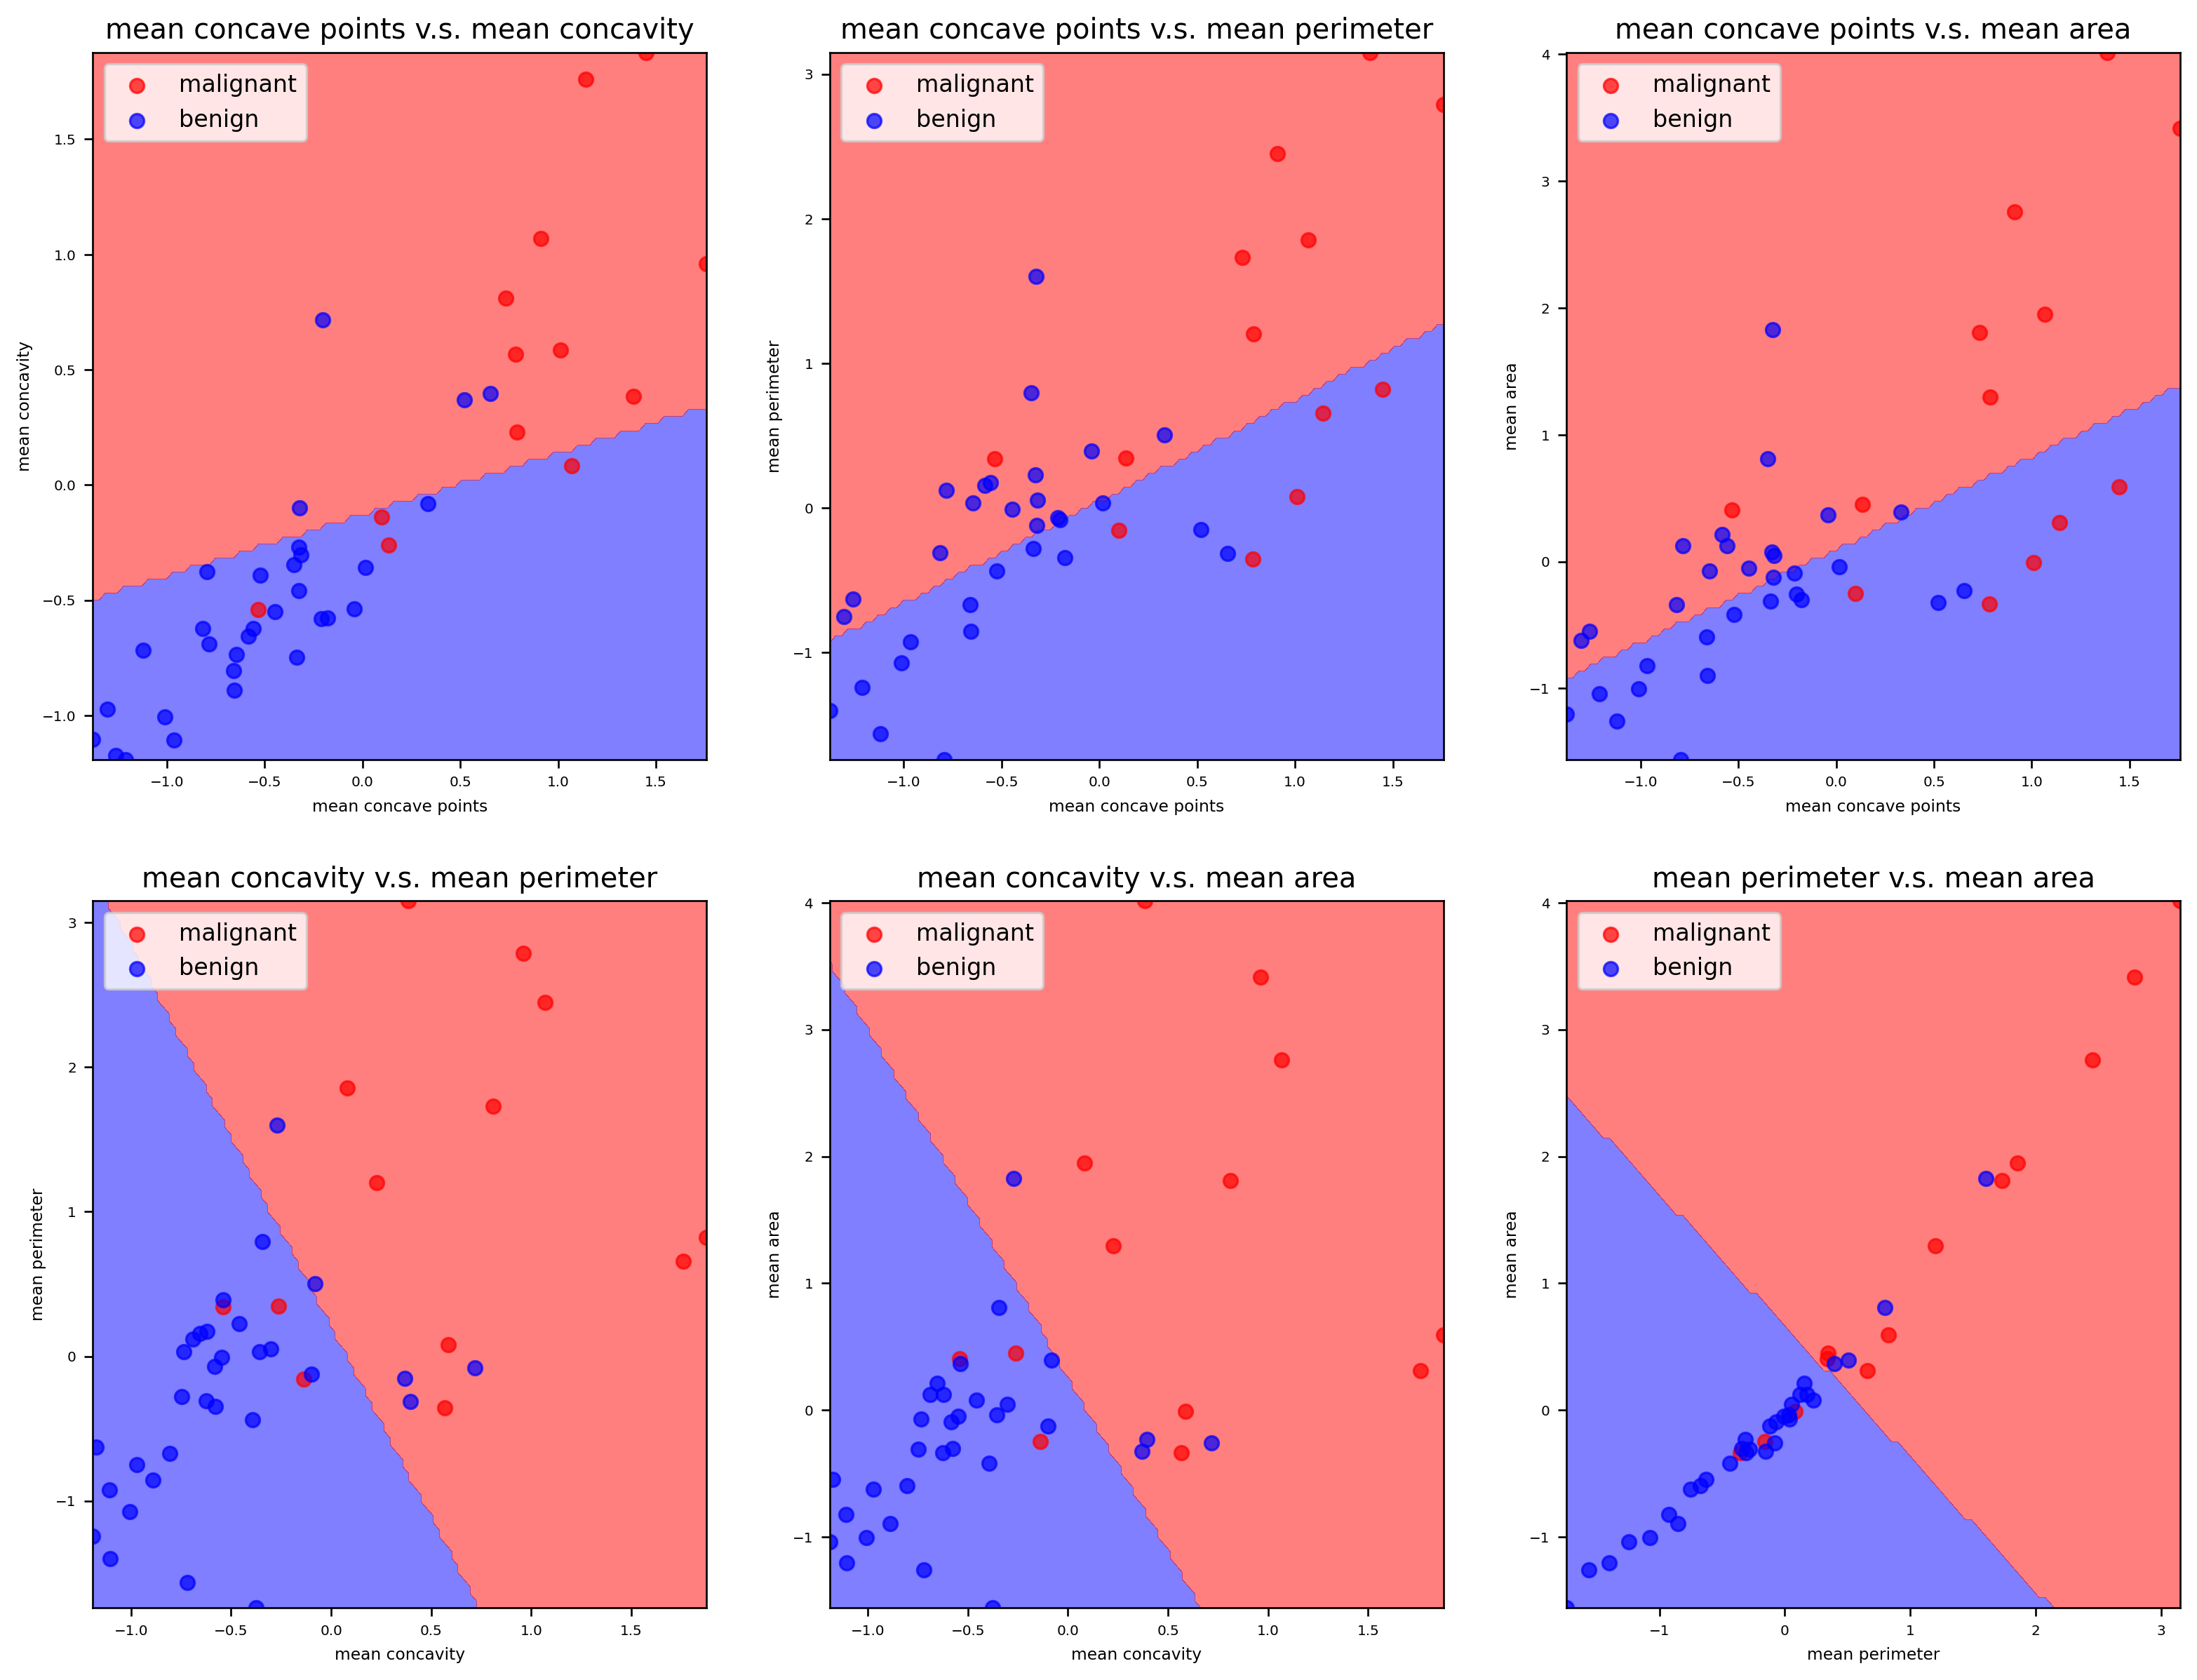

In [11]:
# Your code here

#
# Display the decision boundaries for each pair of features 
# from the best 4 chosen above.
#
xmean = 0.5 * (means_x0 + means_x1)
plt.figure(figsize=(16, 12))
plt.tight_layout()
coutourf_params = {
    'levels': [0, 0.5, 1],
    'colors': ['blue', 'red'],
    'alpha': 0.5,
}

X_pos = X_testp[y_test == 1, :]
X_neg = X_testp[y_test == 0, :]

k = 1
for i in range(4):
    for j in range(i + 1, 4):
        plt.subplot(2, 3, k)
        k += 1

        n1, n2 = best4_index[i], best4_index[j]
        f1, f2 = best4_names[i], best4_names[j]
        xx, yy = make_meshgrid(X_testp[:, n1], X_testp[:, n2])
        plot_contours(best_model, xx, yy, xmean, n1, n2, **coutourf_params)
        plt.scatter(X_pos[:, n1], X_pos[:, n2], marker='o', c='r', alpha=0.7, 
                    label='malignant')
        plt.scatter(X_neg[:, n1], X_neg[:, n2], marker='o', c='b', alpha=0.7,
                    label='benign')

        plt.title(f'{f1} v.s. {f2}')
        plt.xlabel(f1)
        plt.ylabel(f2)
        plt.legend(loc='upper left')
        plt.xlim((xx.min(), xx.max()))
        plt.ylim((yy.min(), yy.max()))
        
plt.show()

### 4.3 Performance specification
**Does the final model meet the client's criteria?  Explain why or why not.** [100 words maximum]

In [12]:
# Answer here
# 
# Based on the final performance on the test data in Q3.2, our model meets 
# the client's criteria. It has 1 false negative and 12 true positives, 
# achieving a 92.3% probability of detecting malignant cancer. 
# Additionally, with 1 false positive and 30 true negatives, it meets the 
# requirement of no more than 1 in 5 healthy cases misclassified.
#
# By handling data effectively, we ensure good input for the model. The SVM 
# model is powerful enough to learn general patterns from the dataset. 
# Utilizing a proper loss function (fbeta, beta = 10), guarantees performance 
# according to the client's criteria.
# 
# [Word count: 97]